### Using Text Classification to Detect Sentiment (Positive, Neutral, or Negative) in Tweets Regarding Airlines
#### Goal: 
The goal of this capstone project is to more effectively determine whether a Tweet to an airline will be positive, neutral, or negative. Understanding the words in Tweets for each sentiment will help the airlines determine what they can do to increase positive sentiment and decrease negative sentiment. I will train four models: Logistic Regression, Naive Bayes, Decision Tree, and Support Vector Classifier (SVC) to detect sentiment from Tweets. Then, I will compare the models to determine the best model, which will be further investigatived in Part 2 (See "Gerber Capstone (Part 2)").

#### Data Problem: 
The data task is to train and tune multi-class classification models that group Tweets into positive (1), neutral (0), and negative (-1) classes.

#### Expected Results: 
The expected results of this capstone project is a high-quality model with high accuracy, recall, and F1 that can be used to predict, from unseen posts, whether their writer has positive, neutral, or negative sentiment.

I will draw insights from this model by conducting an analysis, using the ELI5 and LIME libraries identify the words/features used by the model for making accurate predictions. We will also be locally analyzing this model and evaluating its class prediction process for individual posts. Lastly, we will draw insights from our analyses and recommmend areas to research and courses to undertake for future work in detecting suicide ideation.

#### Data:

The data is from Kaggle.

Link: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

The data are a collection of Tweets from Crowdflower's Data for Everyone library, and posts were collected in February of 2015.

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import time
import warnings
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score,f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Data Overview
- 14640 rows
- 15 columns
    - tweet_id: unique ID for each row
    - airline_sentiment: what the poster's sentiment is ['positive', 'neutral', 'negative']
    - airline_sentiment_confidence: confidence score between 0 and 1
    - negativereason: reason why the sentiment is negative ['Bad Flight', 'Can't Tell', 'Late Flight', 'Customer Service Issue', 'Flight Booking Problems', 'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight', 'Damaged Luggage', 'longlines']
    - negativereason_confidence: confidence score between 0 and 1
    - airline: airline Tweet is directed at ['United', 'US Airways', 'American', 'Southwest', 'Delta', 'Virgin America']	
    - airline_sentiment_gold: Mostly null values (ignore column)
    - name: Twitter handle	
    - negativereason_gold: Mostly null values (ignore column)
    - retweet_count: Number of times Tweet in row was retweeted	
    - text: Content of the Tweet
    - tweet_coord: Longitude and latitude of Tweeter's location
    - tweet_created: Date and time Tweet was posted
    - tweet_location: Location where Tweet was posted
    - user_timezone: Timezone where Tweet was posted

In [2]:
tweets = pd.read_csv("Tweets.csv")
print(tweets.shape)
tweets.head(10)

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [3]:
#sample positive post
print('Sentiment:', tweets['airline_sentiment'].iloc[6])
tweets['text'].iloc[6]

Sentiment: positive


'@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)'

In [4]:
#sample neutral post
print('Sentiment:', tweets['airline_sentiment'].iloc[2])
tweets['text'].iloc[2]

Sentiment: neutral


"@VirginAmerica I didn't today... Must mean I need to take another trip!"

In [5]:
#sample negative post
print('Sentiment:', tweets['airline_sentiment'].iloc[3])
tweets['text'].iloc[3]

Sentiment: negative


'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'

#### Exploratory Data Analysis

In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [8]:
tweets.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

#### Post Length
All posts are over 10 characters and under 200 characters. The most common Tweet length is 140 characters.

In [23]:
#Summary statistics of Tweet length
tweets['length'] = tweets.text.apply(len)
print('Mean Tweet length:', tweets['length'].mean())
print('Minimum Tweet length:', tweets['length'].min())
print('Maximum Tweet length:', tweets['length'].max())

Mean Tweet length: 103.82206284153006
Minimum Tweet length: 12
Maximum Tweet length: 186


(0.0, 200.0)

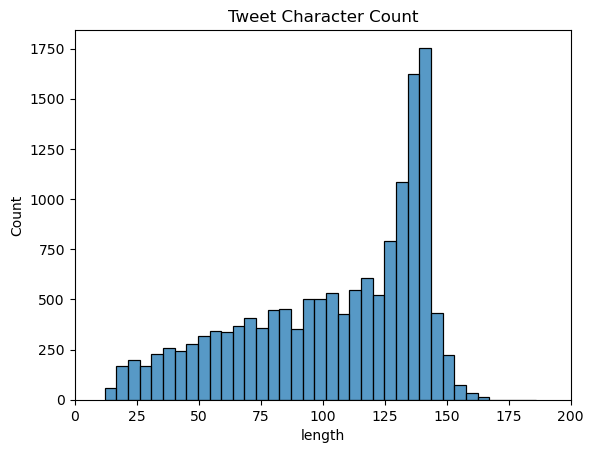

In [10]:
#Tweet length graph
fig, ax = plt.subplots()
sns.histplot(tweets['length'], ax = ax).set_title('Tweet Character Count')
ax.set_xlim(0, 200)

#### Data Distribution
The data is heavily skewed to Neutral sentiment with 62.69%. 21.17% of Tweets have Positive sentiment, and 16.14% of Tweets have Negatie sentiment. It is better to be more balanced; one potential way to remedy this would to be to remove the majority of the Neutral datapoints and some of the positive Tweets so there it is more evenly spread out. This could be an exploratory activity for a future project. 

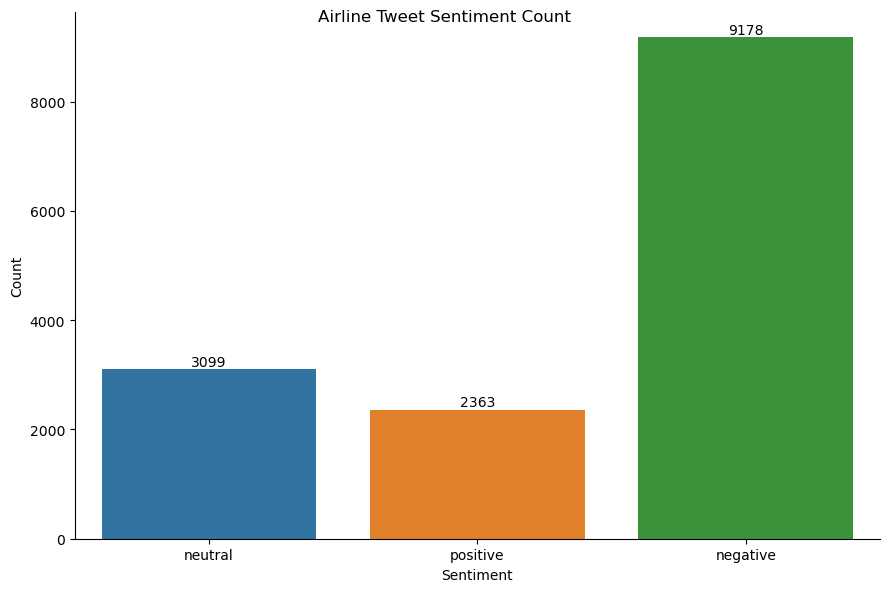

neutral: 62.69%
positive: 21.17%
negative: 16.14%


In [39]:
# Check Tweet Sentiment Distribution with a larger figure size
fig = sns.catplot(x='airline_sentiment', kind='count', data=tweets, height=6, aspect=1.5)
fig.set_axis_labels("Sentiment", "Count")
fig.fig.suptitle("Airline Tweet Sentiment Count")

total_tweets = len(tweets)

for ax in fig.axes.flat:
    ax.bar_label(ax.containers[0])

plt.show()

# Calculate percentages 
percentages = [100 * count / total_tweets for count in tweets['airline_sentiment'].value_counts()]

# Print percentages
for sentiment, percentage in zip(tweets['airline_sentiment'].unique(), percentages):
    print(f"{sentiment}: {percentage:.2f}%")

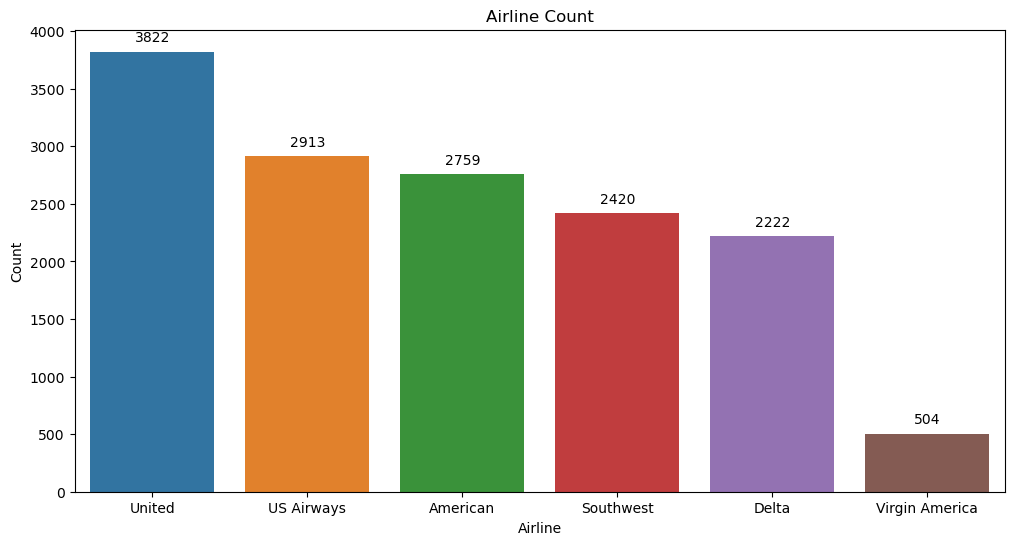

In [40]:
# Check Tweet Time Zone Distribution
fig, ax = plt.subplots(figsize=(12, 6))

# Count and order by descending count
order = tweets['airline'].value_counts().index
sns.countplot(x='airline', data=tweets, ax=ax, order=order)

ax.set(xlabel="Airline", ylabel="Count")
ax.set_title("Airline Count")

# Add labels to the bars (displaying only integer values)
for p in ax.patches:
    count_value = int(p.get_height())  # Convert the count to an integer
    ax.annotate(f'{count_value}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

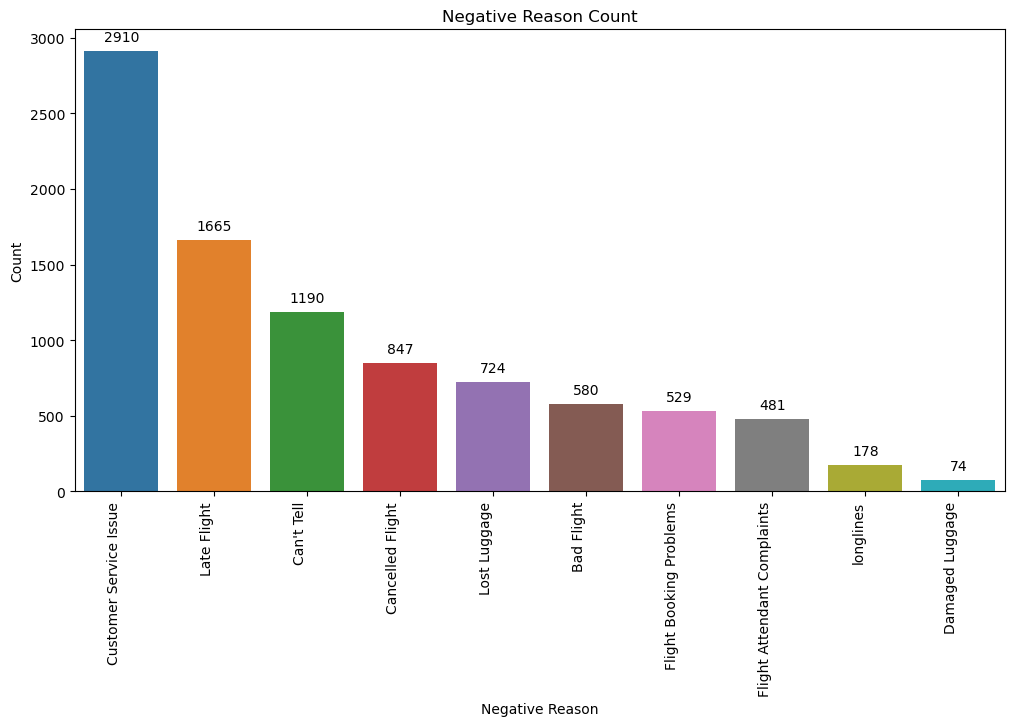

In [42]:
# Check Tweet Sentiment Distribution
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figsize as needed

# Count and order by descending count
order = tweets['negativereason'].value_counts().index
sns.countplot(x='negativereason', data=tweets, ax=ax, order=order)
ax.set(xlabel="Negative Reason", ylabel="Count")
ax.set_title("Negative Reason Count")

# Rotate x-axis labels at a 90-degree angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Add labels to the bars (displaying only integer values)
for p in ax.patches:
    count_value = int(p.get_height())  # Convert the count to an integer
    ax.annotate(f'{count_value}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

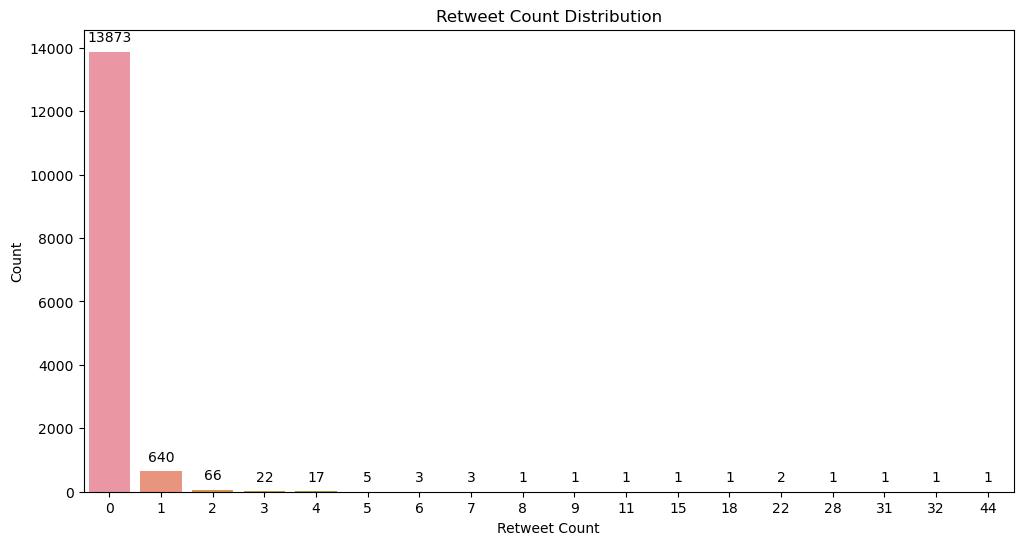

In [43]:
# Check Tweet Sentiment Distribution
fig, ax = plt.subplots(figsize=(12, 6))  

sns.countplot(x='retweet_count', data=tweets, ax=ax)
ax.set(xlabel="Retweet Count", ylabel="Count")
ax.set_title("Retweet Count Distribution")

# Add labels to the bars
for p in ax.patches:
    count_value = int(p.get_height()) 
    ax.annotate(f'{count_value}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

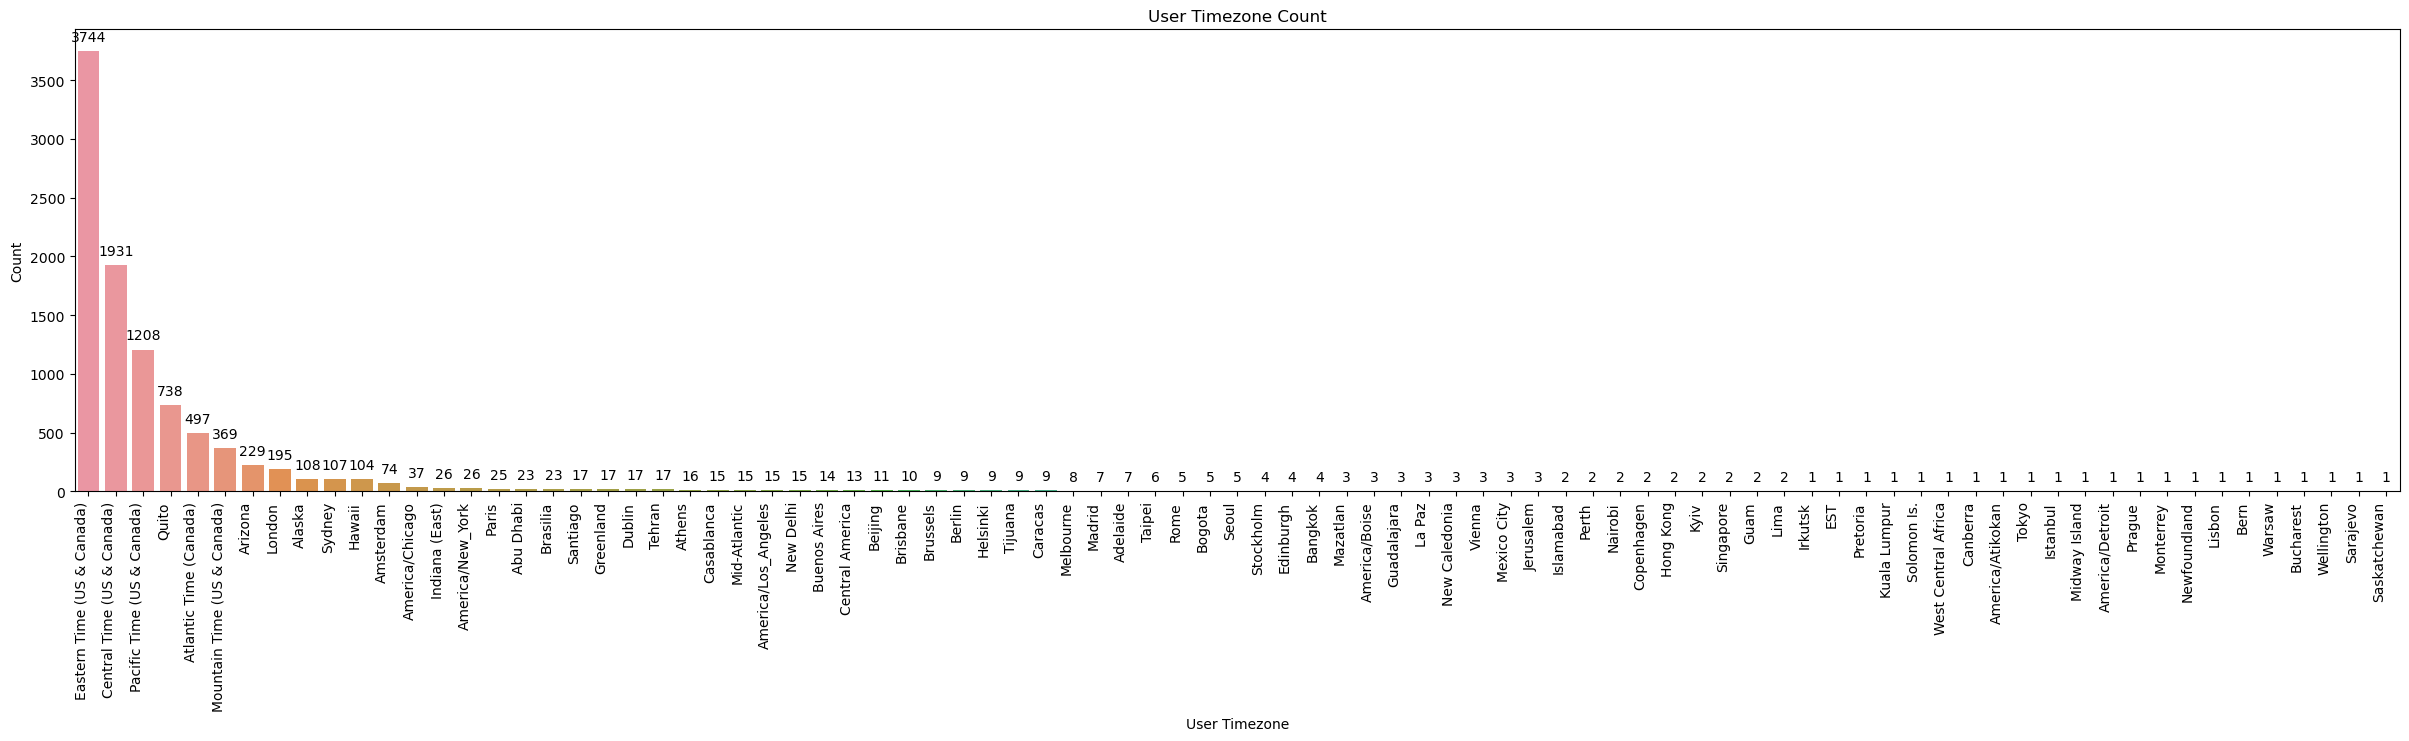

In [44]:
# Check Tweet Sentiment Distribution
fig, ax = plt.subplots(figsize=(30, 6))  # Adjust the figsize as needed

# Count and order by descending count
order = tweets['user_timezone'].value_counts().index
sns.countplot(x='user_timezone', data=tweets, ax=ax, order=order)

ax.set(xlabel="User Timezone", ylabel="Count")
ax.set_title("User Timezone Count")

# Rotate x-axis labels at a 90-degree angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Add labels to the bars (displaying only integer values)
for p in ax.patches:
    count_value = int(p.get_height())  # Convert the count to an integer
    ax.annotate(f'{count_value}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

#### Data Setup

In [45]:
#only keeping the airline sentiment and text columns
columns_to_keep = ['airline_sentiment', 'text']
tweets = tweets[columns_to_keep]


#numerically representing the contents of "airline_sentiment" column
tweets.replace({"positive" : 1, "neutral" : 0, "negative" : -1}, inplace = True)
tweets.head()

,airline_sentiment,text
0,0,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...
2,0,@VirginAmerica I didn't today... Must mean I n...
3,-1,@VirginAmerica it's really aggressive to blast...
4,-1,@VirginAmerica and it's a really big bad thing...


In [46]:
#Train/Test Split
X = tweets['text']
y = tweets['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [47]:
#sample unprocessed post
X_train.iloc[0]

"@united at its worse. Can't figure how to pack plane, screws up connectns then claims no hotl rooms in San Fran for stranded pax. Way to go!"

#### Text Preprocessing
Tokenize posts, remove stop words, punctuation, and capitalization and implement steming on the Tweets. I also removed the tags of the airlines (ex: @VirginAmerica) as I have already graphed how many posts were written at each airline, and this should not change the sentiment of the Tweets.

In [48]:
# Tokenization, stop word removal, punctuation removal, lower casing, and stemming
def preprocess_text(text):
    tokenizer = TweetTokenizer(preserve_case=False)
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    stemmer = PorterStemmer()

    preprocessed_text = []

    for entry in text:
        tokens = tokenizer.tokenize(entry)
        filtered_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and word not in punctuation and not word.startswith('@')]
        preprocessed_text.append(filtered_tokens)

    return preprocessed_text

In [49]:
#Data preprocessing
#Train
pX_train = preprocess_text(X_train)
X_train = [' '.join(x) for x in pX_train]

#Test
pX_test = preprocess_text(X_test)
X_test = [' '.join(x) for x in pX_test]

In [50]:
#Preprocessed post example
X_train[0]

"wors can't figur pack plane screw connectn claim hotl room san fran strand pax way go"

#### Model Training
Four models (Logistic Regression, Naive Bayes, Decision Tree, and SVC) will be trained on the training set and validated with the test set.

#### Logistic Regression
I created a pipeline object to standardize the data using TF-IDF and instantiate a Logistic Regression model. The class is multinomial because there are three potential sentiments that the Tweet can have (positive, neutral, negative).

The stastics are calcualted and displayed after the model is trained.

In [51]:
# Vectorize the text data using TF-IDF and train a Logistic Regression model
lgr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lgr', LogisticRegression(multi_class='multinomial', solver='lbfgs'))
])

# Define the parameters for the randomized search
lgr_params = {
    'lgr__C': [0.1, 1, 10, 100, 1000],
    'lgr__max_iter': [100, 200, 300, 400, 500],
}

# Create the randomized search object
lgr_grid = RandomizedSearchCV(estimator=lgr_pipeline, param_distributions=lgr_params)

# Measure the time taken for training
start = time.time()
lgr_grid.fit(X_train, y_train)
stop = time.time()

# Calculate statistics 
lgr_time = stop - start
lgr_params = lgr_grid.best_params_
lgr_acc = lgr_grid.score(X_test, y_test)
lgr_rec = recall_score(y_test, lgr_grid.predict(X_test), average='weighted')
lgr_f1 = f1_score(y_test, lgr_grid.predict(X_test), average='weighted')

# Display statistics
print(f"Time taken for training: {lgr_time:.2f} seconds")
print(f"Best parameters: {lgr_params}")
print(f"Accuracy: {lgr_acc:.4f}")
print(f"Weighted Recall: {lgr_rec:.4f}")
print(f"Weighted F1 Score: {lgr_f1:.4f}")
print("Classification Report:\n", classification_report(y_test, lgr_grid.predict(X_test)))

/Users/samanthagerber/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/samanthagerber/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Time taken for training: 41.03 seconds
Best parameters: {'lgr__max_iter': 400, 'lgr__C': 1}
Accuracy: 0.7891
Weighted Recall: 0.7891
Weighted F1 Score: 0.7757
Classification Report:
               precision    recall  f1-score   support

          -1       0.81      0.94      0.87      2340
           0       0.67      0.46      0.55       738
           1       0.82      0.61      0.70       582

    accuracy                           0.79      3660
   macro avg       0.76      0.67      0.70      3660
weighted avg       0.78      0.79      0.78      3660



#### Naïve Bayes

I created a pipeline object is to standardize the data using TF-IDF and instantiate a Naïve Bayes model. RandomizedSearchCV is used to find the optimal alpha value between 0.1, 0.5, and 1.0. The optimal value is 0.1.

In [52]:
# Naive Bayes + TF-IDF + Standardization pipeline
nb_tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('standardize', StandardScaler(with_mean=False)),  
    ('nb', MultinomialNB())  
])

# Naive Bayes parameters
nb_params = {
    'nb__alpha': [0.1, 0.5, 1.0],  
    'nb__fit_prior': [True, False]  
}

# Grid search
nb_grid = RandomizedSearchCV(estimator=nb_tfidf_pipe,
                              param_distributions=nb_params,
                              scoring='accuracy',
                              cv=5,
                              n_iter=10,
                              random_state=42)

start = time.time()
nb_grid.fit(X_train, y_train)
stop = time.time()

# Calculate statistics
nb_time = stop - start
nb_best_params = nb_grid.best_params_
nb_acc = nb_grid.score(X_test, y_test)
nb_rec = recall_score(y_test, nb_grid.predict(X_test), average='weighted')
nb_f1 = f1_score(y_test, nb_grid.predict(X_test), average='weighted')

# Print statistics
print(f"Time taken: {nb_time:.2f} seconds")
print("Best parameters:", nb_best_params)
print(f"Accuracy: {nb_acc:.4f}")
print(f"Weighted Recall: {nb_rec:.4f}")
print(f"Weighted F1 Score: {nb_f1:.4f}")

/Users/samanthagerber/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Time taken: 3.92 seconds
Best parameters: {'nb__fit_prior': True, 'nb__alpha': 0.1}
Accuracy: 0.6776
Weighted Recall: 0.6776
Weighted F1 Score: 0.6774


#### Decision Tree

I created a pipeline object to standardize the data using TF-IDF and instantiate a Decision Tree model. RandomizedSearchCV is used to find:
- Optimal tree criterion ('gini', 'entropy'), 
- Max depth (None, 1, 2, 3, 4)
- Minimum sample count required to split a node (1, 2, 3, 4). 

The best model:
- Optimal tree criterion: 'gini'
- Max depth: 4
- Minimum sample split: 1

In [53]:
# Decision tree + TF-IDF pipeline
dt= Pipeline([('tfidf', TfidfVectorizer()),('dt', DecisionTreeClassifier())])

# Decision tree parameters
dt_params = {
    'dt__criterion': ['gini', 'entropy'],  
    'dt__max_depth': [None, 1, 2, 3, 4],  
    'dt__min_samples_split': [1, 2, 3, 4]  
}

# Grid search
tree_grid = RandomizedSearchCV(estimator=dt,
                               param_distributions=dt_params,
                               scoring='accuracy',  
                               cv=5,  
                               n_iter=10,  
                               random_state=42)

start = time.time()
tree_grid.fit(X_train, y_train)
stop = time.time()

# Calculate statistics
dt_time = stop - start
dt_best_params = tree_grid.best_params_
dt_acc = tree_grid.score(X_test, y_test)
dt_rec = recall_score(y_test, tree_grid.predict(X_test), average='weighted')  # Use weighted average for multi-class
dt_f1 = f1_score(y_test, tree_grid.predict(X_test), average='weighted')  # Use weighted average for multi-class

# Print statistics
print(f"Time taken: {dt_time:.2f} seconds")
print("Best parameters:", dt_best_params)
print(f"Accuracy: {dt_acc:.4f}")
print(f"Weighted Recall: {dt_rec:.4f}")
print(f"Weighted F1 Score: {dt_f1:.4f}")

Time taken: 7.38 seconds
Best parameters: {'dt__min_samples_split': 1, 'dt__max_depth': 4, 'dt__criterion': 'gini'}
Accuracy: 0.6932
Weighted Recall: 0.6932
Weighted F1 Score: 0.6176


#### Support Vector Classifier 
I created a pipeline object to standardize the data using TF-IDF and instantiate a SVC model using a linear kernel. RandomizedSearchCV is used to find:
- Optimal C value (0.1, 1, 10, 100, 1000)
- Probability (True, False)

The best model:
- Optimal C value:
- Probability: 

In [54]:
# Define the pipeline with TF-IDF vectorizer and Support Vector Classifier (SVC)
svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC(kernel='linear'))
])

# Define the parameters for randomized search
svc_params = {
    'svc__C': [0.1, 1, 10, 100, 1000],
    'svc__probability': [True, False]
}

# Create the randomized search object
svc_grid = RandomizedSearchCV(estimator=svc, param_distributions=svc_params)

# Measure time for training
start = time.time()
svc_grid.fit(X_train, y_train)
stop = time.time()

# Calculate statistics
svc_time = stop - start
svc_params = svc_grid.best_params_
svc_acc = svc_grid.score(X_test, y_test)
svc_rec = recall_score(y_test, svc_grid.predict(X_test), average='weighted')
svc_f1 = f1_score(y_test, svc_grid.predict(X_test), average='weighted')

# Print Statistics
print(f"Time taken for training: {svc_time} seconds")
print(f"Best parameters: {svc_params}")
print(f"Accuracy: {svc_acc}")
print(f"Weighted Recall: {svc_rec}")
print(f"Weighted F1 Score: {svc_f1}")

Time taken for training: 1268.0088481903076 seconds
Best parameters: {'svc__probability': True, 'svc__C': 1}
Accuracy: 0.7912568306010929
Weighted Recall: 0.7912568306010929
Weighted F1 Score: 0.7807594107592237


#### Model evaluation 
- Best Speed: 3.922773 (Naive Bayes)
- Best Accuracy: 0.791257 (SVC)
- Best Recall: 0.791257 (SVC)
- Best F1: 0.780759 (SVC)

In [55]:
#Build results df 
results_df = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'SVC'], 
              'Speed' : [lgr_time, dt_time, nb_time, svc_time],
              'Best Params': [lgr_params, dt_params, nb_best_params, svc_params],
              'Accuracy': [lgr_acc, dt_acc, nb_acc, svc_acc],
              'Recall' : [lgr_rec, dt_rec, nb_rec, svc_rec],
              'F1' : [lgr_f1, dt_f1, nb_f1, svc_f1]}).set_index('Model') 
#Show results
results_df

,Speed,Best Params,Accuracy,Recall,F1
Model,,,,,
Logistic Regression,41.032191,"{'lgr__max_iter': 400, 'lgr__C': 1}",0.789071,0.789071,0.775683
Decision Tree,7.375702,"{'dt__criterion': ['gini', 'entropy'], 'dt__ma...",0.693169,0.693169,0.617618
Naive Bayes,3.922773,"{'nb__fit_prior': True, 'nb__alpha': 0.1}",0.677596,0.677596,0.677376
SVC,1268.008848,"{'svc__probability': True, 'svc__C': 1}",0.791257,0.791257,0.780759


#### Confusion Matrices
Key:
- FP = False Positive
- FN = False Negative

Note: there are FP and FN for each class.

##### Logistic Regression:
- FP: 184
- FN: 588
- 3-4x more FN than FP

##### Naive Bayes:
- FP: 613
- FN: 567
- Slightly more FP than FN

##### Decision Tree
- FP: 167
- FN: 954
- 5-6x more FN than FP

##### SCV
- FP: 226
- FN: 538
- 2-3x more FN thanm FP

In [56]:
#Compile predictions
log_preds = lgr_grid.predict(X_test)
nb_preds = nb_grid.predict(X_test)
tree_preds = tree_grid.predict(X_test)
svc_preds = svc_grid.predict(X_test)

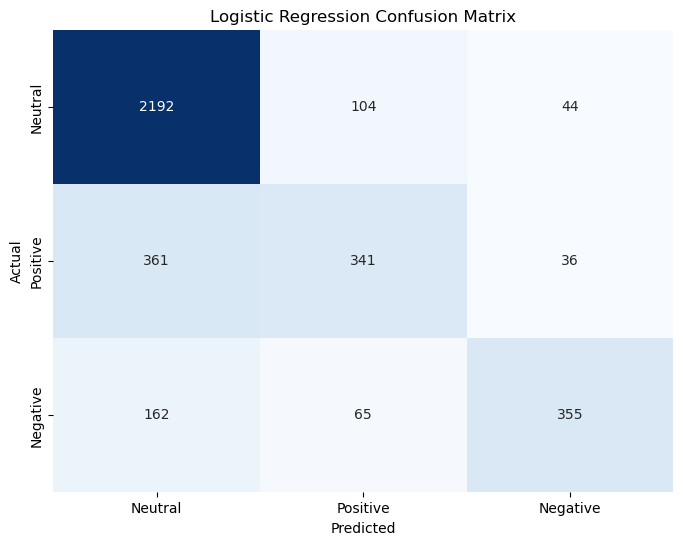

In [57]:
# Create matrix for Logitic Regression
conf_matrix_logreg = confusion_matrix(y_test, log_preds)

# Plot the confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Neutral', 'Positive', 'Negative'],
            yticklabels=['Neutral', 'Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

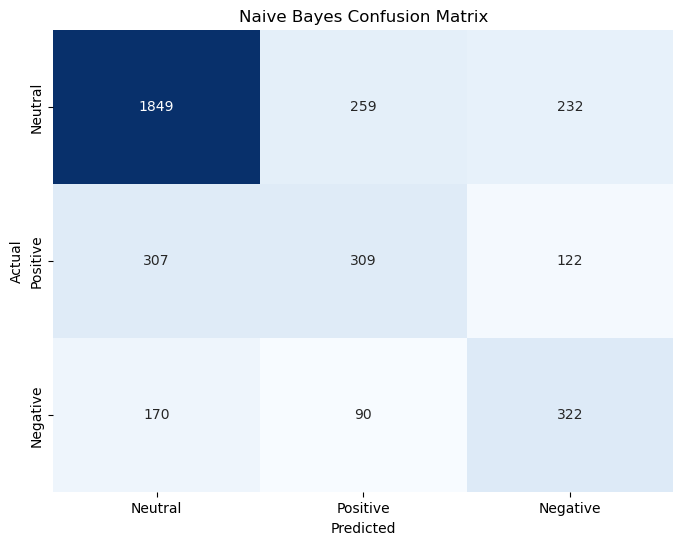

In [58]:
# Create matrix for Naive Bayes
conf_matrix_nb = confusion_matrix(y_test, nb_preds)

# Plot the confusion matrix for Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Neutral', 'Positive', 'Negative'],
            yticklabels=['Neutral', 'Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

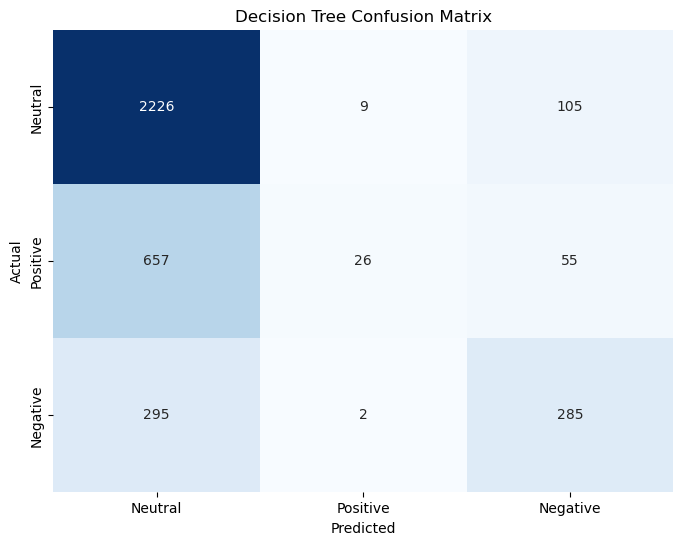

In [59]:
# Create matrix for Decision Tree
conf_matrix_dt = confusion_matrix(y_test, tree_preds)

# Plot the confusion matrix for Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Neutral', 'Positive', 'Negative'],
            yticklabels=['Neutral', 'Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

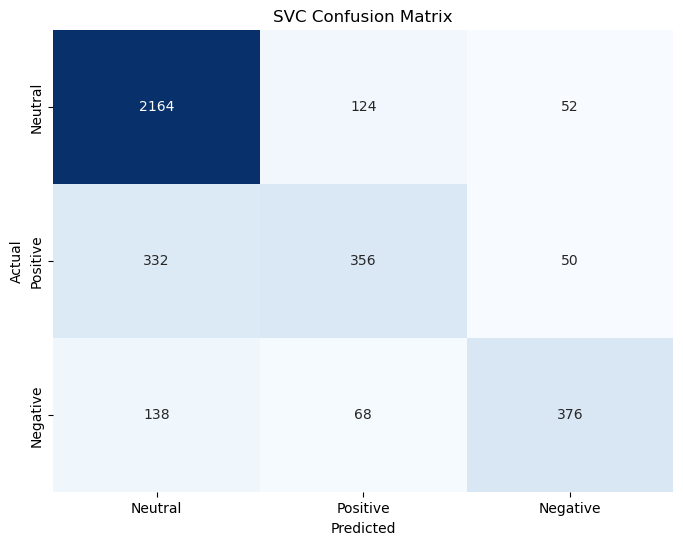

In [60]:
# Create matrix for SVC
conf_matrix_svc = confusion_matrix(y_test, svc_preds)

# Plot the confusion matrix for Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Neutral', 'Positive', 'Negative'],
            yticklabels=['Neutral', 'Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVC Confusion Matrix')
plt.show()

### Select the best model

The SVC model is the best model with the highest Accuracy, Recall, and F1. After adding up the FPs and FNs from each model, the SVC model has the least total. The Logistic Regressionm model is a close second. The Accuracy, Recall, and F1 are all very slightly smaller than SVC's, and the confusion matrix has slightly more FPs and FNs (when added together). While SVC is the best model, it is worth noting that the time to train the model is significantly greater than any other model (1223.410604) compared to Logistic Regression which is the second greatest (33.538042). SVC takes over 36x longer to train than Logistic Regression, over 171x longer than Decision Tree (7.148970), and over 297x longer than Naive Bayes (4.113052).

I will be further exploring the SVC model and the data question in another file titled "Gerber Capstone (Part 2)" which is also in my GitHub.